In [1]:
#import necessary libraries
from typing import Optional
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
#add utility functions from tensorflow
def meshgrid_xy(tensor1: torch.Tensor, tensor2: torch.Tensor)->(torch.Tensor, torch.Tensor):
    """Mimick np.meshgrid(..., indexing="xy") in pytorch. torch.meshgrid only allows "ij" indexing.
    (If you're unsure what this means, safely skip trying to understand this, and run a tiny example!)

    Args:
      tensor1 (torch.Tensor): Tensor whose elements define the first dimension of the returned meshgrid.
      tensor2 (torch.Tensor): Tensor whose elements define the second dimension of the returned meshgrid.
    """
    
    ii, jj = torch.meshgrid(tensor1, tensor2, indexing='xy');  #support xy now
    return ii, jj;
    #return ii.transpose(-1 -2), jj.transpose(-1, -2);


def cumprod_exclusive(tensor: torch.Tensor)->torch.Tensor:
    """Mimick functionality of tf.math.cumprod(..., exclusive=True), as it isn't available in PyTorch.

      Args:
        tensor (torch.Tensor): Tensor whose cumprod (cumulative product, see `torch.cumprod`) along dim=-1
          is to be computed.

      Returns:
        cumprod (torch.Tensor): cumprod of Tensor along dim=-1, mimiciking the functionality of
          tf.math.cumprod(..., exclusive=True) (see `tf.math.cumprod` for details).
    """

    #only works for the last dimension(dim=-1)
    dim = -1;
    #Compute regular comprod first this is equivalent to `tf.math.cumprod(..., exclusive=False)`)
    cumprod = torch.cumprod(tensor, dim);
    #Roll the elements
    cumprod = torch.roll(cumprod, 1, dim);
    #Replace the first element by "1" as this is what tf.cumprod(..., exclusive=True) does.
    cumprod[..., 0] = 1.

    return cumprod


In [3]:
def get_ray_bundle(height: int, width: int, focal_length: float, tform_cam2world: torch.Tensor):
    """Compute the bundle of rays passing through all pixels of an image (one ray per pixel).

    Args:
    height (int): Height of an image (number of pixels).
    width (int): Width of an image (number of pixels).
    focal_length (float or torch.Tensor): Focal length (number of pixels, i.e., calibrated intrinsics).
    tform_cam2world (torch.Tensor): A 6-DoF rigid-body transform (shape: :math:`(4, 4)`) that
      transforms a 3D point from the camera frame to the "world" frame for the current example.

    Returns:
    ray_origins (torch.Tensor): A tensor of shape :math:`(width, height, 3)` denoting the centers of
      each ray. `ray_origins[i][j]` denotes the origin of the ray passing through pixel at
      row index `j` and column index `i`.
      (TODO: double check if explanation of row and col indices convention is right).
    ray_directions (torch.Tensor): A tensor of shape :math:`(width, height, 3)` denoting the
      direction of each ray (a unit vector). `ray_directions[i][j]` denotes the direction of the ray
      passing through the pixel at row index `j` and column index `i`.
      (TODO: double check if explanation of row and col indices convention is right).
    """
    ii, jj = meshgrid_xy(
        torch.arange(width).to(tform_cam2world),
        torch.arange(height).to(tform_cam2world)
    )
    #[-0.5:0.5,-0.5"0.5, -1]
    directions = torch.stack([(ii-width*0.5)/focal_length,
                            -(jj-height*0.5)/focal_length,
                              -torch.ones_like(ii)
                             ], dim=-1);
    #torch.sum(directions[..., None, :]*tform_cam2world[:3, :3], dim=-1)
    ray_directions =  torch.sum(directions[..., None, :]*tform_cam2world[:3, :3], dim=-1) #directions@tform_cam2world[:3,:3] 
    #print(f"ray_drections shape {ray_directions.shape}");
    ray_origins = tform_cam2world[:3, -1].expand(ray_directions.shape);
    return ray_origins, ray_directions;
    

In [4]:
def compute_query_points_from_rays(
    ray_origins: torch.Tensor,
    ray_directions: torch.Tensor,
    near_thresh: float,
    far_thresh: float,
    num_samples: int,
    randomize: Optional[bool] = True
)-> (torch.Tensor, torch.Tensor):
    """Compute query 3D points given the "bundle" of rays. The near_thresh and far_thresh
  variables indicate the bounds within which 3D points are to be sampled.

  Args:
    ray_origins (torch.Tensor): Origin of each ray in the "bundle" as returned by the
      `get_ray_bundle()` method (shape: :math:`(width, height, 3)`).
    ray_directions (torch.Tensor): Direction of each ray in the "bundle" as returned by the
      `get_ray_bundle()` method (shape: :math:`(width, height, 3)`).
    near_thresh (float): The 'near' extent of the bounding volume (i.e., the nearest depth
      coordinate that is of interest/relevance).
    far_thresh (float): The 'far' extent of the bounding volume (i.e., the farthest depth
      coordinate that is of interest/relevance).
    num_samples (int): Number of samples to be drawn along each ray. Samples are drawn
      randomly, whilst trying to ensure "some form of" uniform spacing among them.
    randomize (optional, bool): Whether or not to randomize the sampling of query points.
      By default, this is set to `True`. If disabled (by setting to `False`), we sample
      uniformly spaced points along each ray in the "bundle".
  
  Returns:
    query_points (torch.Tensor): Query points along each ray
      (shape: :math:`(width, height, num_samples, 3)`).
    depth_values (torch.Tensor): Sampled depth values along each ray
      (shape: :math:`(num_samples)`).
    """
    #no special sampling techniques introduced
    depth_values = torch.linspace(near_thresh, far_thresh, num_samples).to(ray_origins)
    if randomize is True:
        #ray_origins: (width, height, 3)
        #noise_shape = (width, height, num_samples)
        noise_shape = list(ray_origins.shape[:-1])+[num_samples]
        noise_tensor = torch.tensor(noise_shape);
        #depth values: (num_samples)
        depth_values = depth_values+ torch.rand(noise_shape).to(ray_origins)*(far_thresh - near_thresh)/num_samples
        #print(f"noise value shapes: {noise_tensor.shape}");
        #print(f"depth value shapes: {depth_values.shape}");
        #(width, height, num_samples, 3) = (width, height, 1, 3) + (width, height, 1, 3) * (num_samples, 1)
        #query_points (width, height, num_samples, 3)
        query_points = ray_origins[..., None, :] + ray_directions[..., None, :]*depth_values[..., :, None];
        #print(f"depth value shapes: {depth_values.shape}");
        return query_points, depth_values

In [5]:
#function test
tform_cam2world = torch.zeros((4,4));
tform_cam2world[0,0]= tform_cam2world[1,1] = tform_cam2world[2,2] = tform_cam2world[3,3]= 1.0;
ro, rd = get_ray_bundle(8, 6, 3, tform_cam2world);
_, _ = compute_query_points_from_rays(ro, rd, 0.1, 100, 8);

## Volumetric Rendering

In [6]:
#volumetric rendering
'''
This volumetric rendering module (like the authors' tiny_nerf Colab notebook does not implement 5D input
(which includes view directions, in addition to X, Y, Z coordinates). 
It also does not implement the hierarchical sampling procedure. 
For those implementations, refer to the other complete examples in the repo.
'''
def render_volume_density(
    radiance_field: torch.Tensor,
    ray_origins: torch.Tensor,
    depth_values: torch.Tensor
    )-> (torch.Tensor, torch.Tensor, torch.Tensor):
    r"""Differentiably renders a radiance field, given the origin of each ray in the
    "bundle", and the sampled depth values along them.

    Args:
    radiance_field (torch.Tensor): A "field" where, at each query location (X, Y, Z),
      we have an emitted (RGB) color and a volume density (denoted :math:`\sigma` in
      the paper) (shape: :math:`(width, height, num_samples, 4)`).
    ray_origins (torch.Tensor): Origin of each ray in the "bundle" as returned by the
      `get_ray_bundle()` method (shape: :math:`(width, height, 3)`).
    depth_values (torch.Tensor): Sampled depth values along each ray
      (shape: :math:`(num_samples)`).

    Returns:
    rgb_map (torch.Tensor): Rendered RGB image (shape: :math:`(width, height, 3)`).
    depth_map (torch.Tensor): Rendered depth image (shape: :math:`(width, height)`).
    acc_map (torch.Tensor): # TODO: Double-check (I think this is the accumulated
      transmittance map).
    """
    sigma_a = torch.nn.functional.relu(radiance_field[..., 3]);
    rgb = torch.sigmoid(radiance_field[..., :3])
    one_e_10 = torch.tensor([1e10], dtype=ray_origins.dtype, device=ray_origins.device)
    dists = torch.cat((depth_values[..., 1:] - depth_values[..., :-1], one_e_10.expand(depth_values[..., :1].shape)), dim = -1)
    alpha = 1. - torch.exp(-sigma_a * dists);  # avoid unexpected negatives
    
    weights = alpha*cumprod_exclusive(1. - alpha + 1e-10);
    rgb_map = (weights[..., None]*rgb).sum(dim=-2);
    depth_map = (weights*depth_values).sum(dim=-1);
    acc_map = weights.sum(-1)
    
    return rgb_map, depth_map, acc_map;

## Positional Encoding

In [7]:
#Positional encoding -> high-frequency functions
def position_encoding(
    tensor, num_encoding_functions=6, include_input=True, log_sampleing=True
    )->torch.Tensor:
    """Apply positional encoding to the input.

    Args:
    tensor (torch.Tensor): Input tensor to be positionally encoded.
    num_encoding_functions (optional, int): Number of encoding functions used to
        compute a positional encoding (default: 6).
    include_input (optional, bool): Whether or not to include the input in the
        computed positional encoding (default: True).
    log_sampling (optional, bool): Sample logarithmically in frequency space, as
        opposed to linearly (default: True).

    Returns:
    (torch.Tensor): Positional encoding of the input tensor.
    """
    #Tested
    #include input tensor to the encoding?
    encoding = [tensor] if include_input else []
    frequency_bands = None
    if log_sampleing:
        frequency_bands = 2.0 ** torch.linspace(
            0.0,
            num_encoding_functions-1,
            num_encoding_functions,
            dtype=tensor.dtype,
            device=tensor.device
        )
    else:
         frequency_bands = torch.linspace(
            2.0**0.0,
            2.0**(num_encoding_functions-1),
            num_encoding_functions,
            dtype=tensor.dtype,
            device=tensor.device
        )
    for freq in frequency_bands:
        for func in [torch.sin, torch.cos]:
            encoding.append(func(tensor*freq));
    
    if len(encoding) ==1:
        return encoding[0];
    else:
        return torch.cat(encoding, dim=-1)


## Tiny NeRf Network Architecture

In [8]:
class VeryTinyNerfModel(torch.nn.Module):
    #only three fully connected layers
    def __init__(self, filter_size=128, num_encoding_functions=6):
        super(VeryTinyNerfModel, self).__init__()
        #Input Layer (default 39 -> 128)
        self.layer1 = torch.nn.Linear(3+3*2*num_encoding_functions, filter_size);
        #layer 2 (default 128 ->128)
        self.layer2 = torch.nn.Linear(filter_size, filter_size)
        #Layer 3 (default: 128 ->4)
        self.layer3 = torch.nn.Linear(filter_size, 4);
        self.relu =  torch.nn.functional.relu
        
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x);
        return x;


## DataLoading Utils

In [9]:
def get_minibatches(inputs: torch.Tensor, chunksize: Optional[int] = 1024 * 8):
  r"""Takes a huge tensor (ray "bundle") and splits it into a list of minibatches.
  Each element of the list (except possibly the last) has dimension `0` of length
  `chunksize`.
  """
  return [inputs[i:i + chunksize] for i in range(0, inputs.shape[0], chunksize)]


import os
if not os.path.exists('tiny_nerf_data.npz'):
    !wget "http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz"

## Determine device to run on (GPU vs CPU)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Load up input images, poses, intrinsics

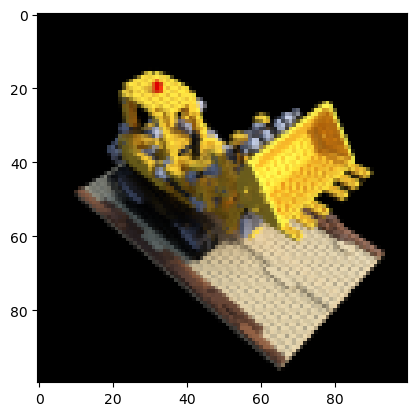

In [11]:
#Load input images, poses, int intrinsics
data = np.load('tiny_nerf_data.npz')

#Images
images = data['images']

#Camera Extrinsics (Poses)
tform_cam2world = data['poses']
tform_cam2world = torch.from_numpy(tform_cam2world).to(device)

#Focal Length (intrinsics)
focal_length = data['focal']
focal_length = torch.from_numpy(focal_length).to(device)

#Height and width of each image
height, width = images.shape[1:3]

#Near and far clipping thresholds ofr depth values
near_thresh = 2.
far_thresh = 6.

#Hold one image out (for test)
testimg, testpose = images[101], tform_cam2world[101];
testimg = torch.from_numpy(testimg).to(device)

#map images to device
images = torch.from_numpy(images[:100, ..., :3]).to(device)

tt = np.clip(testimg.cpu().numpy(), 0.0, 1.0);
plt.imshow(tt)
plt.show()

## TrainNeRF

In [12]:
#one iteration of TinyNeRF (forward pass)
def run_one_iter_of_tinynerf(height, width, focal_length, tform_cam2world,
                             near_thresh, far_thresh, depth_samples_per_ray,
                             encoding_function, get_minibatches_function):
    #Get the "Bundle" of rays through all image pixels
    ray_origins, ray_directions = get_ray_bundle(height, width, focal_length, tform_cam2world)
    
    #sample query points along each ray
    query_points, depth_values = compute_query_points_from_rays(ray_origins, ray_directions, near_thresh, far_thresh, depth_samples_per_ray)
    
    #Flattern the query points
    flattened_query_points = query_points.reshape((-1, 3))
    
    #Encode the query points
    encoded_points = encoding_function(flattened_query_points)
    
    #Split the encoded points into "chunks", run the model on all chunks
    #Concatenate the results to avoid out of memory issues
    batches = get_minibatches_function(encoded_points, chunksize=chunksize);
    predictions = []
    for batch in batches:
        predictions.append(model(batch))
    radiance_field_flattened = torch.cat(predictions, dim=0)
    #print(f"radiance field shape: {radiance_field_flattened.shape}");
    #unflatten to obtain the radiance field (may need to check shape)
    unflattened_shape = list(query_points.shape[:-1]) +[4]; #form a nerf
    #print(f"unflattened_shape: {unflattened_shape}");
    radiance_field = torch.reshape(radiance_field_flattened, unflattened_shape)
    
    #perform differentiable volume rendering to re-synthesis the RGB image
    rgb_predicted, _, _ = render_volume_density(radiance_field, ray_origins, depth_values);
    
    return rgb_predicted

Loss:  0.14664748311042786


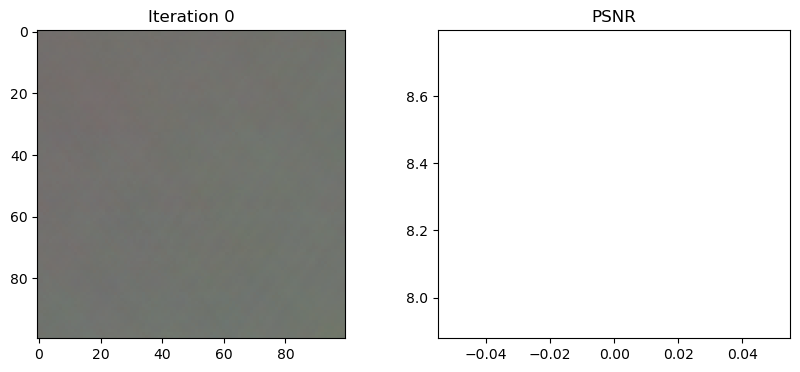

Loss:  0.026644840836524963


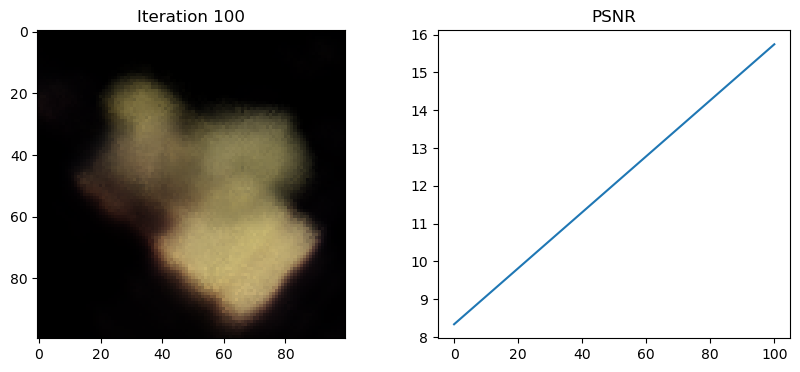

Loss:  0.09703446924686432


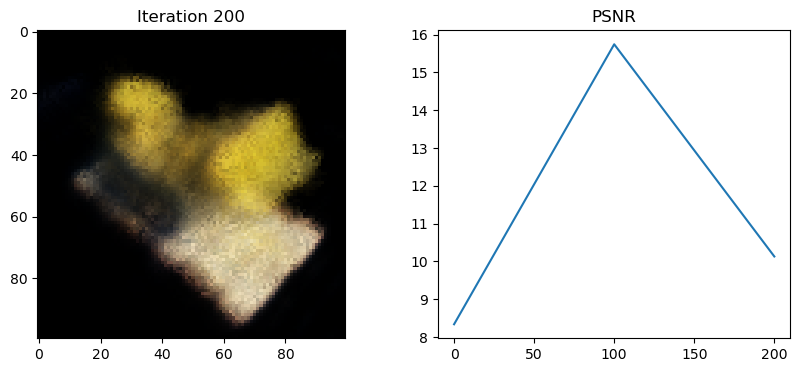

Loss:  0.099787138402462


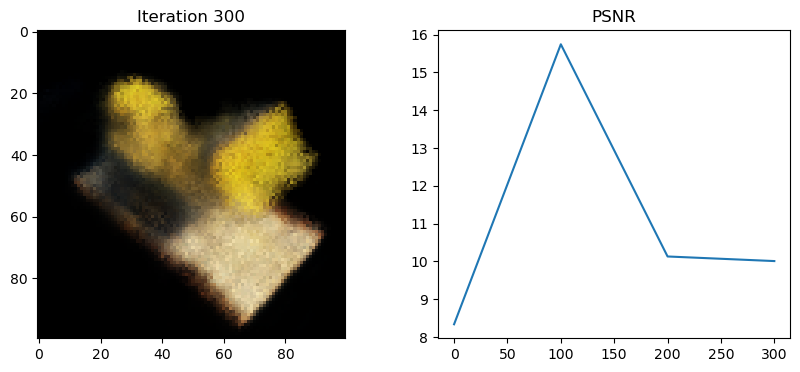

Loss:  0.07819672673940659


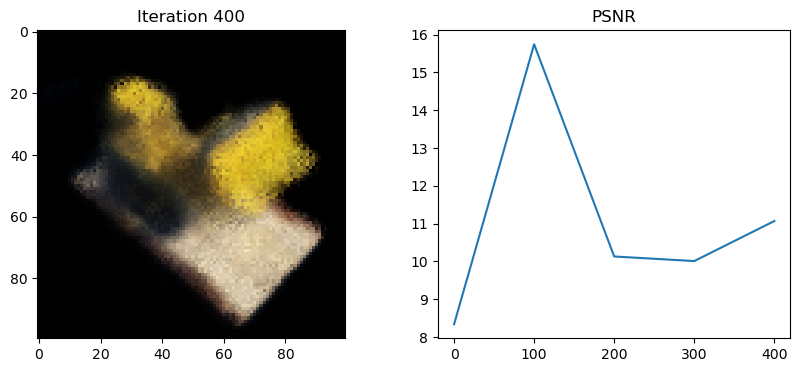

Loss:  0.051818519830703735


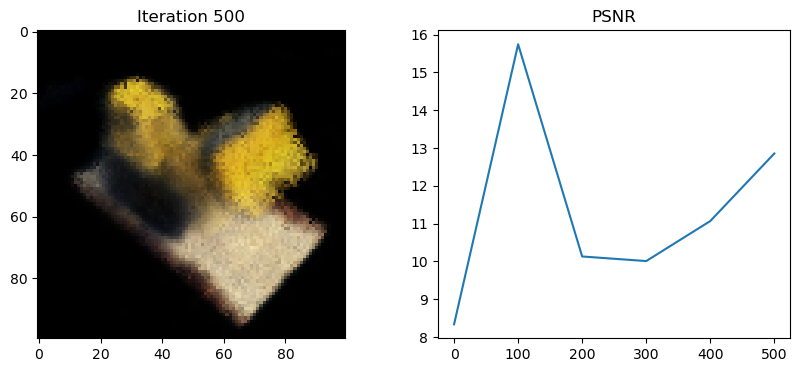

Loss:  0.10244311392307281


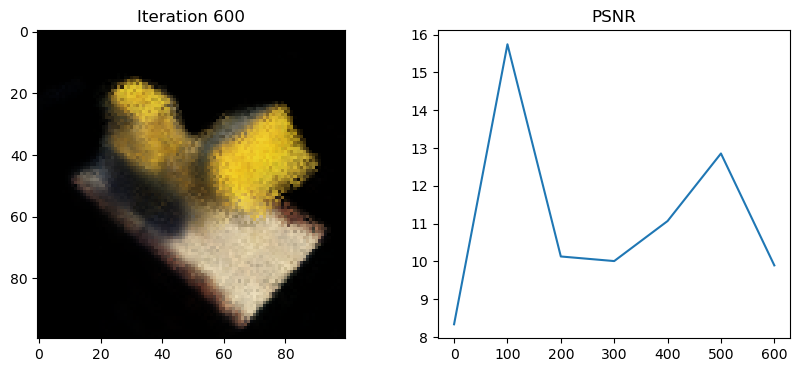

Loss:  0.09658762812614441


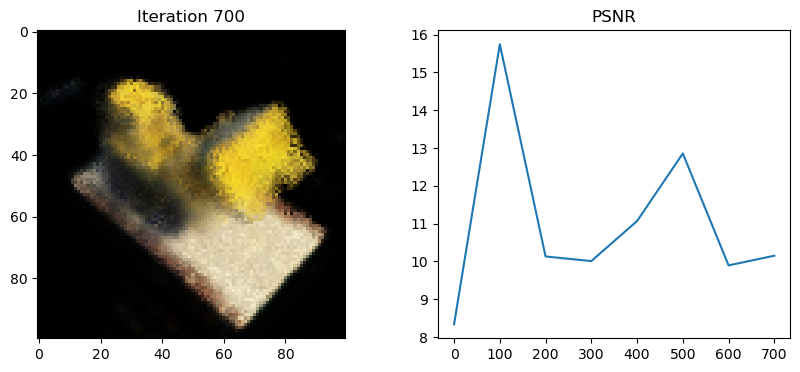

Loss:  0.09339679777622223


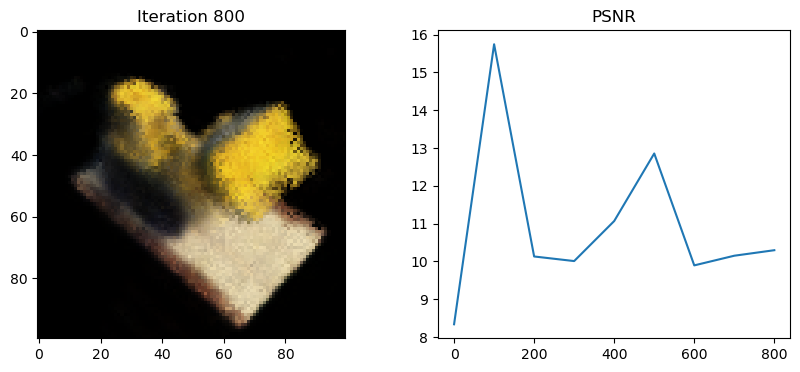

Loss:  0.0704788938164711


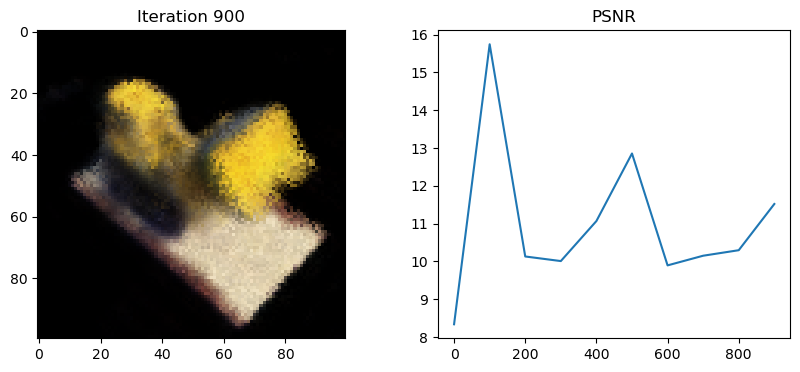

Loss:  0.03835613280534744


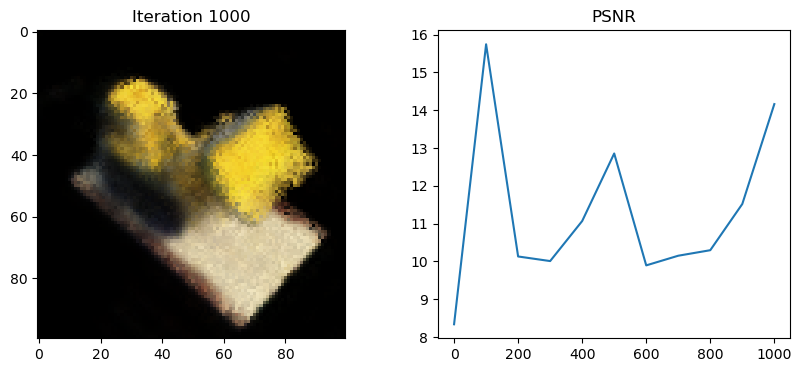

Loss:  0.06543052196502686


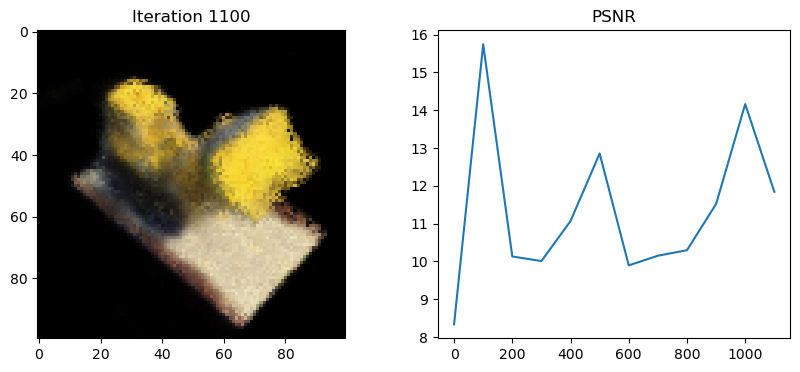

Loss:  0.09460800886154175


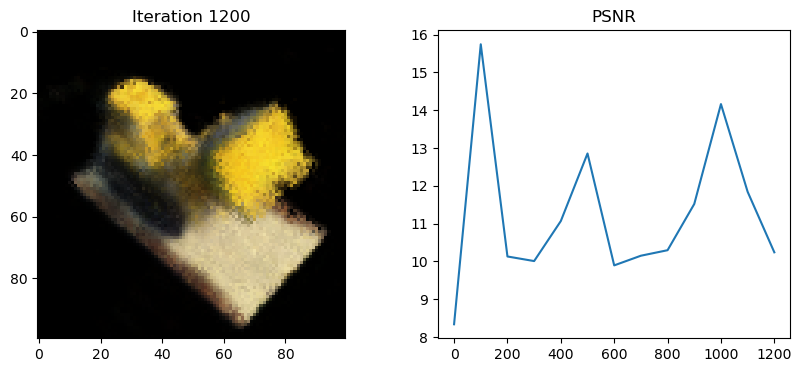

Loss:  0.08623738586902618


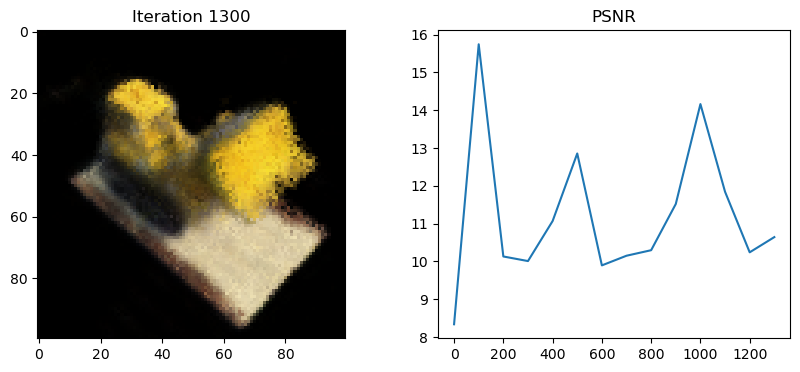

Loss:  0.08605608344078064


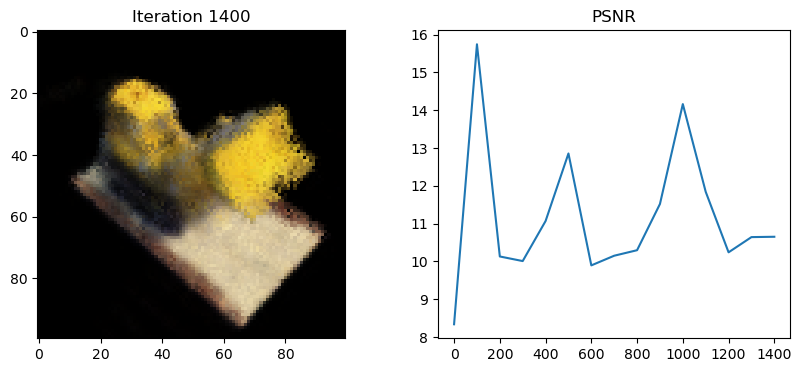

Loss:  0.10694606602191925


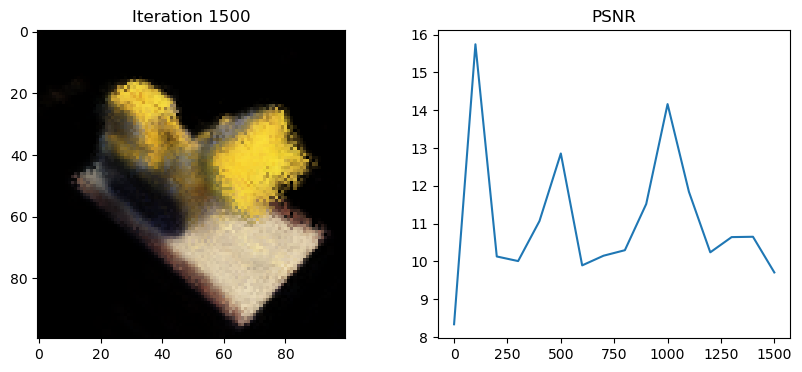

Loss:  0.0936800166964531


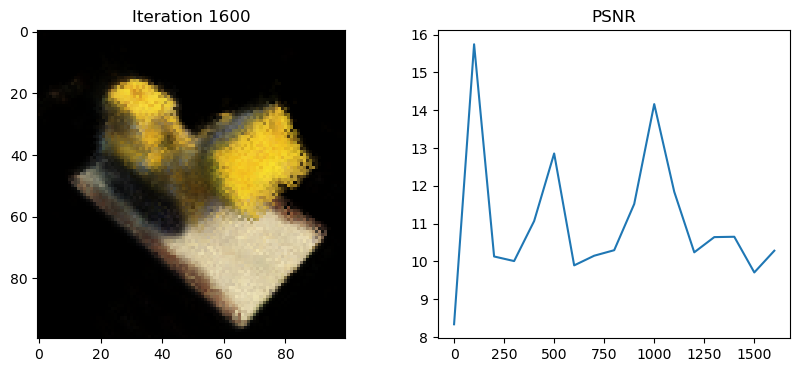

Loss:  0.10356694459915161


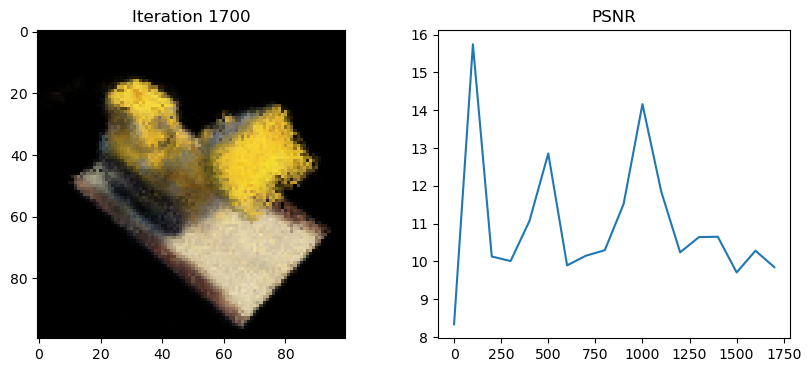

Loss:  0.08466825634241104


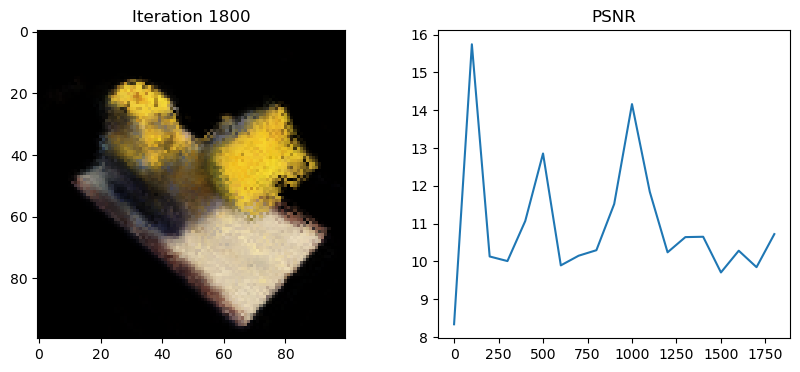

Loss:  0.15039892494678497


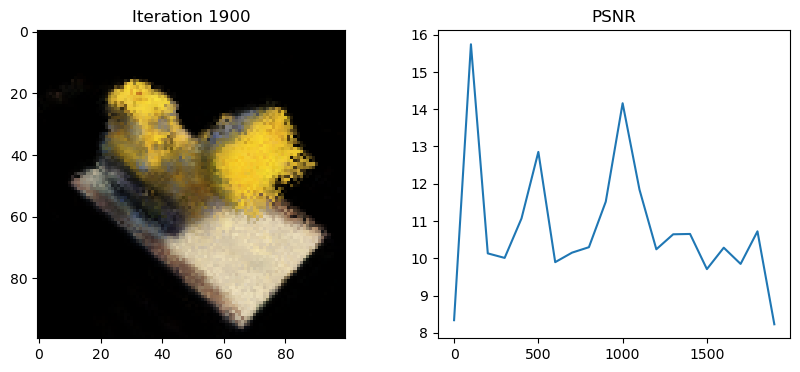

Loss:  0.15099549293518066


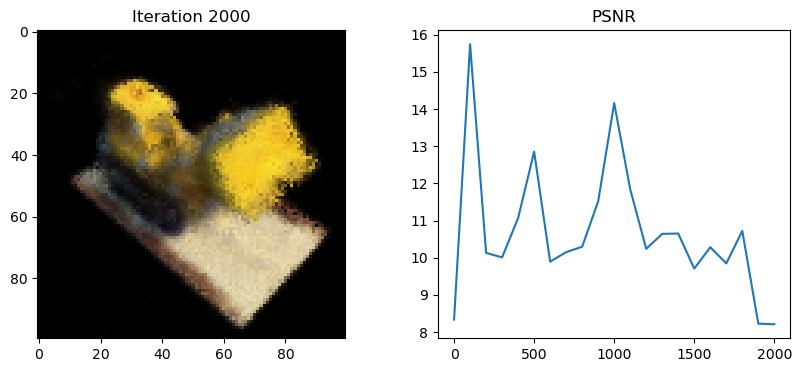

Loss:  0.10079480707645416


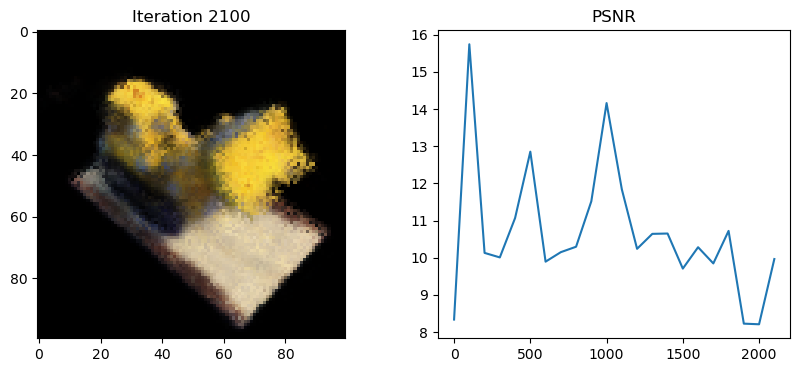

Loss:  0.11904348433017731


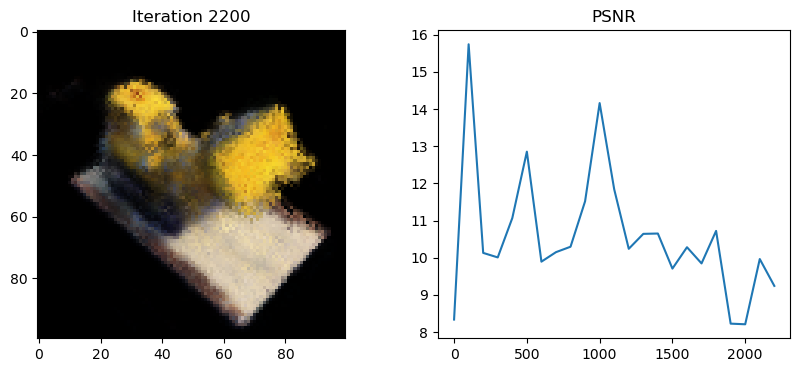

Loss:  0.13555091619491577


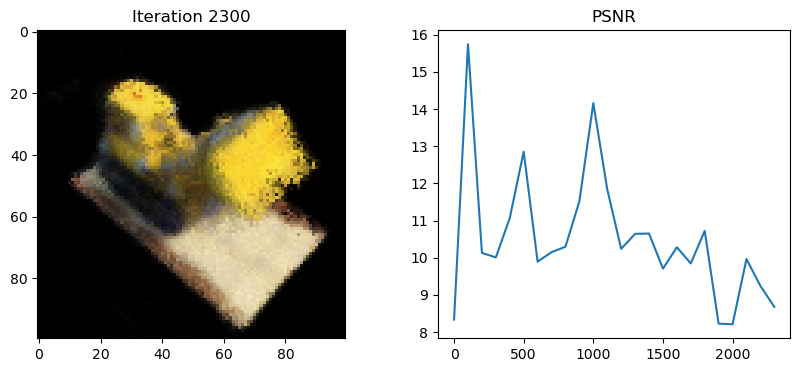

Loss:  0.09754297137260437


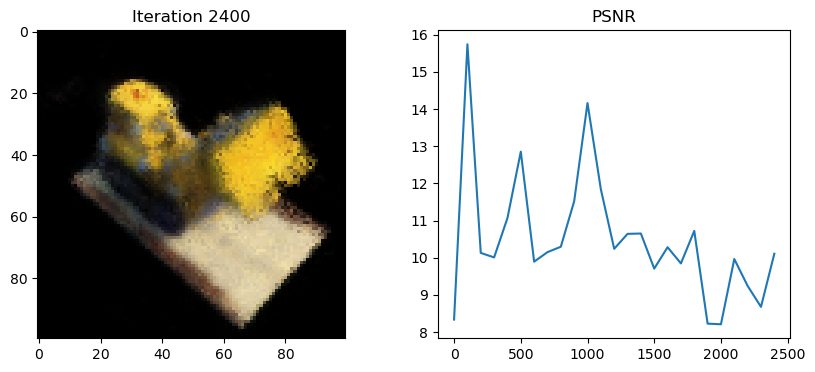

Loss:  0.11463123559951782


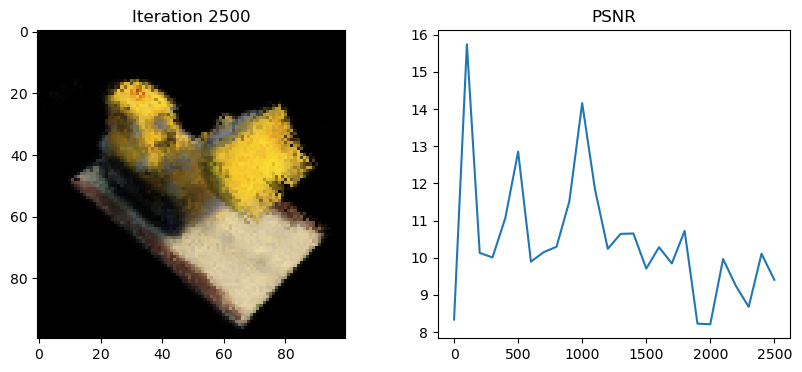

Loss:  0.08675449341535568


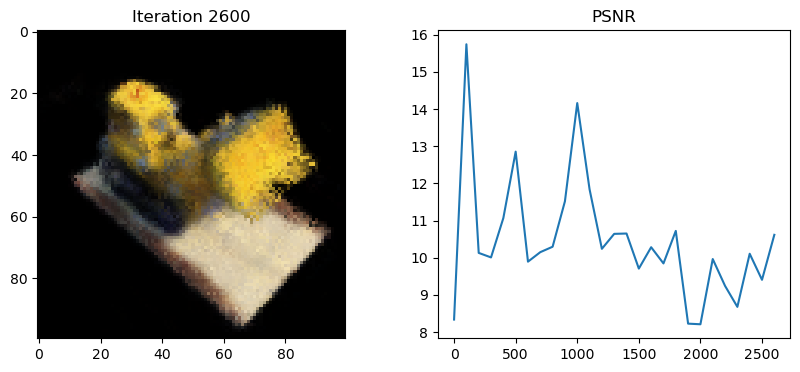

Loss:  0.07737363129854202


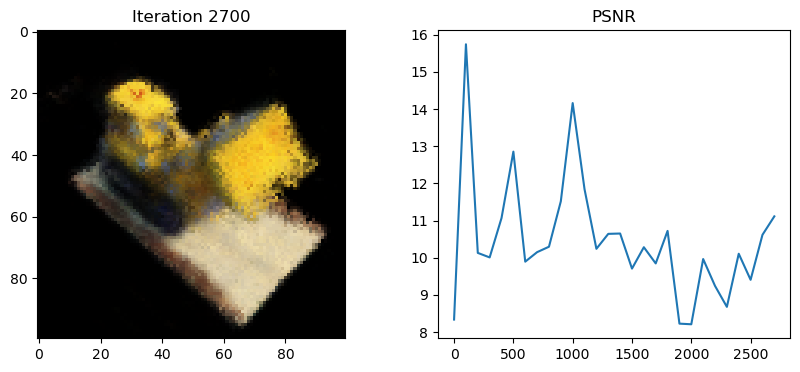

Loss:  0.14765560626983643


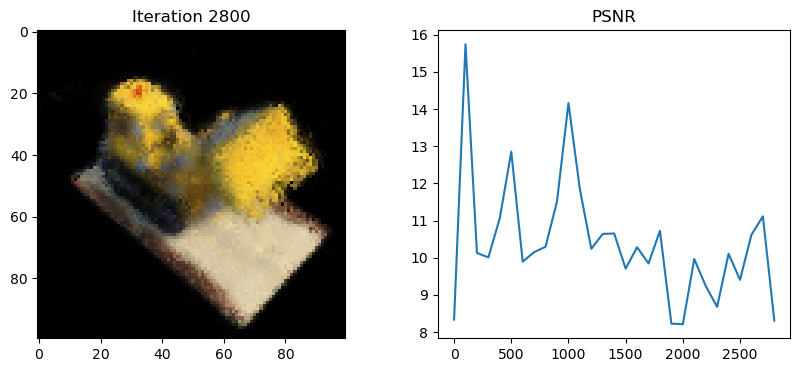

Loss:  0.11266984790563583


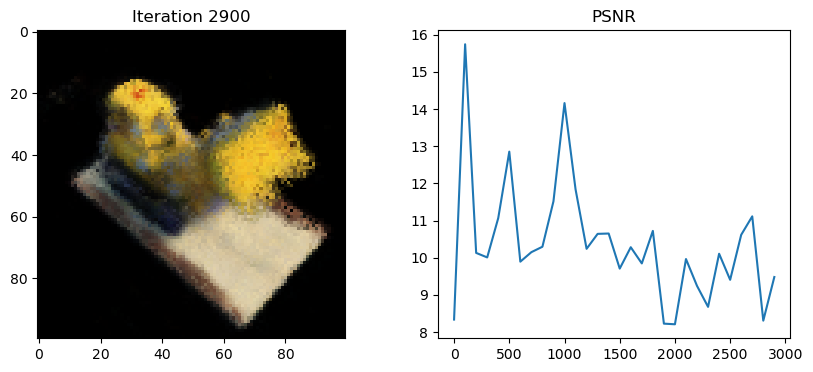

Done!


In [13]:
#Hyper Parameters for TinyNeRF training

#Number of functions used in the positional encoding
num_encoding_functions = 6
#Specify encoding function
encode = lambda x: position_encoding(x, num_encoding_functions=num_encoding_functions)
#Number of depth samples along each ray
depth_samples_per_ray = 32;

#Chunksize
chunksize = 4096

#Optimizer parameters
lr = 5e-3;
num_iters = 3000;

#Misc parameters
display_every = 100;  #number of iters after which stats are displayed

#Model
model = VeryTinyNerfModel(num_encoding_functions=num_encoding_functions)
model.to(device)  #to cuda

#Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr);

#Train-Eval-Repeat

#Seed RNG for repeatability
seed = 9458
torch.manual_seed(seed)
np.random.seed(seed)

#Lists to log metrics etc.
psnrs = []
iternums = []

for i in range(num_iters):
    
    #Randomly pick an image as the target
    target_img_idx = np.random.randint(images.shape[0]);
    target_img = images[target_img_idx].to(device)
    target_tform_cam2world = tform_cam2world[target_img_idx].to(device);
    
     # Run one iteration of TinyNeRF and get the rendered RGB image.
    rgb_predicted = run_one_iter_of_tinynerf(height, width, focal_length,
                                           target_tform_cam2world, near_thresh,
                                           far_thresh, depth_samples_per_ray,
                                           encode, get_minibatches)

    # Compute mean-squared error between the predicted and target images. Backprop!
    loss = torch.nn.functional.mse_loss(rgb_predicted, target_img)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    #Run one iteration of TinyNeRF and get the rendered RGB images
    if i % display_every == 0:
        rgb_predicted = run_one_iter_of_tinynerf(height, width, focal_length,
                                                 testpose, near_thresh,
                                                 far_thresh, depth_samples_per_ray,
                                                 encode, get_minibatches)

        loss = torch.nn.functional.mse_loss(rgb_predicted, target_img);
        print("Loss: ", loss.item())
        psnr = -10. * torch.log10(loss);
        psnrs.append(psnr.item());
        iternums.append(i);

        plt.figure(figsize=(10, 4))
        plt.subplot(121)
        plt.imshow(rgb_predicted.detach().cpu().numpy())
        plt.title(f"Iteration {i}")
        plt.subplot(122)
        plt.plot(iternums, psnrs)
        plt.title("PSNR")
        plt.show();
    
print("Done!");
